In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from src.data.make_tflite_graph import load_tflite_model
import pickle as pk

2022-05-10 14:12:09.224248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64/:/usr/local/cuda-10.2/lib64:/usr/local/cuda-10.2/extras/CUPTI/lib64:
2022-05-10 14:12:09.224283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
def getRandomImage():
    # imgDir = "/data_2/Anonymous/data/imagenet/labelled"
    imgDir = "/opt/Anonymous/workspace/mob-dl-rev/data/external/roads"
    length = len(os.listdir(imgDir))
    idx = np.random.randint(low=0, high=length)
    img = Image.open("{}/{}".format(imgDir, os.listdir(imgDir)[idx]))
    # img.show()
    return img

def drawImg(img, points):
    from PIL import ImageDraw
    # print("Points:", points)
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    color = [[255,255,0],[255,0,0],[0,255,0],[0,0,255]]
    r = 3
    for i in range(len(points)):
        for p in points[i]:
            x, y = p[1], p[2]
            # print(x, y)
            draw.ellipse((x-r, y-r, x+r, y+r), fill=tuple(color[i]))
    display(img_copy)

In [2]:

import sys
import tflite

def calc_flops(path):
    with open(path, 'rb') as f:
        buf = f.read()
        model = tflite.Model.GetRootAsModel(buf, 0)

    graph = model.Subgraphs(0)

    # help(tflite.BuiltinOperator)
    # ABS = 101
    # CONV_2D = 3
    # CUMSUM = 128

    # print funcs
    _dict_builtin_op_code_to_name = {v: k for k, v in  tflite.BuiltinOperator.__dict__.items() if type(v) == int}
    # def print_header():
    #     print("%-18s | M FLOPS" % ("OP_NAME"))
    #     print("------------------------------")
    # def print_flops(op_code_builtin, flops):
    #     print("%-18s | %.1f" % (_dict_builtin_op_code_to_name[op_code_builtin], flops / 1.0e6))
    # def print_none(op_code_builtin):
    #     print("%-18s | <IGNORED>" % (_dict_builtin_op_code_to_name[op_code_builtin]))
    # def print_footer(total_flops):
    #     print("------------------------------")
    #     print("Total: %.1f M FLOPS" % (total_flops / 1.0e6))

    total_flops = 0.0
    # print_header()
    for i in range(graph.OperatorsLength()):
        op = graph.Operators(i)
        op_code = model.OperatorCodes(op.OpcodeIndex())
        op_code_builtin = op_code.BuiltinCode()

        op_opt = op.BuiltinOptions()

        flops = 0.0
        if op_code_builtin == tflite.BuiltinOperator.CONV_2D:
            # input shapes: in, weight, bias
            in_shape = graph.Tensors( op.Inputs(0) ).ShapeAsNumpy()
            filter_shape = graph.Tensors( op.Inputs(1) ).ShapeAsNumpy()
            bias_shape = graph.Tensors( op.Inputs(2) ).ShapeAsNumpy()
            # output shape
            out_shape = graph.Tensors( op.Outputs(0) ).ShapeAsNumpy()
            # ops options
            opt = tflite.Conv2DOptions()
            opt.Init(op_opt.Bytes, op_opt.Pos)
            # opt.StrideH()

            # flops. 2x means mul(1)+add(1). 2x not needed if you calculate MACCs
            # refer to https://github.com/AlexeyAB/darknet/src/convolutional_layer.c `l.blopfs =`
            flops = 2 * out_shape[1] * out_shape[2] * filter_shape[0] * filter_shape[1] * filter_shape[2] * filter_shape[3]
            # print_flops(op_code_builtin, flops)

        elif op_code_builtin == tflite.BuiltinOperator.DEPTHWISE_CONV_2D:
            in_shape = graph.Tensors( op.Inputs(0) ).ShapeAsNumpy()
            filter_shape = graph.Tensors( op.Inputs(1) ).ShapeAsNumpy()
            out_shape = graph.Tensors( op.Outputs(0) ).ShapeAsNumpy()
            # flops
            flops = 2 * out_shape[1] * out_shape[2] * filter_shape[0] * filter_shape[1] * filter_shape[2] * filter_shape[3]
            # print_flops(op_code_builtin, flops)

        else:
            pass
            # print_none(op_code_builtin)

        total_flops += flops
    # print_footer(total_flops)
    return total_flops

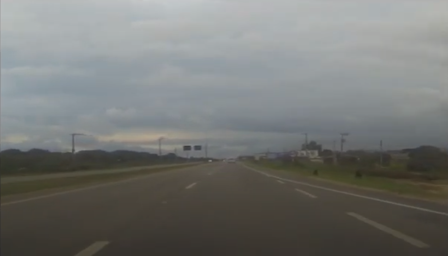

In [3]:
from IPython.display import display
img = getRandomImage()
# img = img.resize(size=(224, 224))
# img = img.resize(size=(300, 300))
img = img.resize(size=(448, 256))
display(img)

In [ ]:
import easydict

model_path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/tflite_model/com.mm.youliao_47/nsfw.tflite"
model_path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/tflite_model/4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_float32.tflite"

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
print(interpreter.get_input_details())
print(interpreter._get_ops_details()[3])
print(interpreter.get_tensor_details()[6])
# print(interpreter.get_tensor_details()[11])
# origin_kernel = interpreter.get_tensor(104)
# for x in interpreter._get_ops_details():
#     # print(x)
#     if 6 in x["inputs"]:
#         print(x)
# print([layer.name for layer in keras_model.get_layer('model').layers])

In [ ]:
# model_path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/tflite_model/com.mm.youliao_47/nsfw.tflite"
model_path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/tflite_model/4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_float32.tflite"

# g, w = load_tflite_model(model_path)
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
print(input_shape)

x = np.asarray(img).astype(np.float32)

# Handle PNG picture
if x.shape[-1] == 4:
    x = x[...,:-1]


# x = np.stack([x[:,:,0], x[:,:,2], x[:,:,1]])
x = x[..., (0, 2, 1)]
x = x.reshape(1, 256, 448, 3)
# print(x.shape)

# x[:, :, 0] -= 123
# x[:, :, 1] -= 117
# x[:, :, 2] -= 104
# x = x[:, :, ::-1]  # RGB -> BGR
# x = x.reshape(1, 224, 224, 3)


# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], x)

interpreter.invoke()

# output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])


print(output_data.shape)
print(output_data)
# print(output_details[0]['index'])
# tmp = interpreter.get_tensor(8)
# print(tmp)

# print(interpreter.get_tensor(11))
# print(interpreter.get_tensor(0))
# output_data = interpreter.get_tensor(34)

# print(output_data)
# print(tf.constant(output_data[0,0,0,:] - bias))

# print(0.74438494/0.0000465527773485519) 
# 15990.129534627118


points = [[],[],[],[]]
for i in range(256):
    for j in range(448):
        if output_data[0,i,j] != 0:
            t = output_data[0,i,j]
            t = int(t) - 1
            points[t-1].append([t, j, i])
# points = []
# for i in range(len(output_details)):
#     if i == 0:
#         continue
#     output_data = interpreter.get_tensor(output_details[i]['index'])
#     points.append([])
#     print(output_details[i]["name"])
#     output_data = output_data[0]
#     print(["{:.2f}".format(x) for x in list(output_data)])
#     for j in range(2):
#         # print(output_data)
#         points[-1].append([i, int(448*output_data[2*j]), int(256*output_data[2*j+1])])

        # points[-1].append([i, int(448*output_data[2*j+1]), 256-int(256*output_data[2*j])])
# 0.74438494  0.10050604  0.2959381   0.24925673  2.2578614   1.3281488

In [ ]:
# Draw segmentation result in the lane detection task
drawImg(img, points)

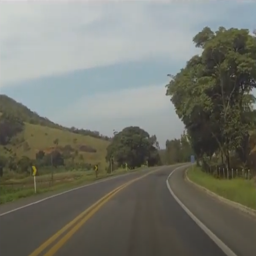

(256, 256, 4)
tf.Tensor(
[[[347.47717 363.681   395.2409  ... 394.12494 361.08618 328.9626 ]
  [365.40536 382.533   420.01013 ... 429.72922 391.18143 354.96692]
  [391.16965 414.98193 455.67426 ... 477.2313  434.34494 393.13092]
  ...
  [376.44275 406.54636 443.08884 ... 562.5679  522.88367 470.80853]
  [353.19556 383.30933 417.32898 ... 525.538   496.727   455.07977]
  [330.34836 356.5474  387.4516  ... 504.94232 469.82312 433.37125]]], shape=(1, 256, 256), dtype=float32)


In [17]:
import imp
# dynamic import
def dynamic_imp(name, class_name):
	
	try:
		fp, path, desc = imp.find_module(name)
	except ImportError:
		print ("module not found: " + name)
		
	try:
		example_package = imp.load_module(name, fp, path, desc)
	except Exception as e:
		print(e)
  
	try:
		myclass = imp.load_module("% s.% s" % (name, class_name), fp, path, desc)
	except Exception as e:
		print(e)
		
	return example_package, myclass

# path = "/opt/Anonymous/workspace/mob-dl-rev/data/processed/tflite_model/com.mm.youliao_47/nsfw.tflite"
# path = "/opt/Anonymous/workspace/mob-dl-rev/data/processed/tflite_model/4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_float32.tflite"
# path = "/opt/Anonymous/workspace/mob-dl-rev/data/processed/tflite_model/ai.fritz.heartbeat_2019-04-25/poppy_field_400x300_025.tflite"
path = "/opt/Anonymous/workspace/mob-dl-rev/data/processed/tflite_model/394a999ea7925d1204c62ec74ddf2805/hed_lite_model_quantize.tflite"

class_name = "model"
mod, modCl = dynamic_imp(path, class_name=class_name)

img = getRandomImage()
img = img.resize(size=(256, 256))
x = np.array(img)
display(img)
print(x.shape)
if x.shape[-1] == 4:
    x = x[..., :-1]
x = x.reshape(1, 256, 256, 3)
x = tf.constant(x)
out = modCl.model(x)
print(out)

In [3]:
paths = [
# "apk-com.ghost.sibyl/converted_model_v2_1.tflite",
# "com.iart.camera.photo_2019-07-10/converted_model_v2_1.tflite",
# "apk-faceapp.facemystery.learnmoreaboutyourself/converted_model_v2_1.tflite",
# "wallpaper.transparent/deeplabv3_mnv2_pascal_trainval.tflite",
# "ru.photostrana.mobile_2019-07-23/model.tflite",
# "com.lanyueming.ps/lite-model_deeplabv3_1_metadata_2.tflite",
# "com.lanyueming.ps/deeplabv3_257_mv_gpu.tflite",
# "com.blink.academy.nomo/deeplabv3_257_mv_gpu.tflite",
# "8920ba71741fc9002de446b07c1d24bf_46231900/deeplabv3_257_mv_gpu.tflite",
# "com.jrj.androidtop/model_v13_q.tflite",
# "com.steam.photoeditor_2019-07-04/converted_model_1.tflite",
# "ai.fritz.heartbeat_2019-04-25/hair_a050_224x224_5_1554502837.tflite",
# "com.mm.youliao_47/nsfw.tflite",
# "com.tencent.ipai_2111111/output_graph.tflite",
# "com.appsverse.photonapplock/recibos_optimized_graph.tflite",
# "com.abbyy.mobile.textgrabber.full_258/CropableClassifierV1.tflite",
# "apk-com.estsoft.picnic/squeeze_sky_net_0104.tflite",
# "6b8453244849cec836a149321590d499/15_Scene_detection.tflite",
# "lite_demo_efficientdet2/lite-model_efficientdet_lite2_detection_metadata_1.tflite",
# "a_i_glass_apkpure.com/detect.tflite",
# "org.prudhvianddheeraj.lite.example.detection/detect.tflite",
# "com.infocomltd.ugvassistant_2019-08-05/detect.tflite",
# "com.yilab.tensorflow.lite.examples.detection/detect.tflite",
# "6b8453244849cec836a149321590d499/object_detect.tflite",
# "com.zuoyebang.airclass/person_detect.tflite",
# "a2e8130e0bec9c72eb82487dbf3e403b_28027500/person_detect.tflite",
# "com.zuoyebang.airclass/hand_detect_quantized_model.tflite",
# "a2e8130e0bec9c72eb82487dbf3e403b_28027500/hand_detect_quantized_model.tflite",
# "4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_float32.tflite",
# "com.sogou.map.android.maps_100907000/lane_detection_v2.2.0_float32.tflite",
# "975fb88e0abe835264b654adf638b096/lane_detection_v2.2.0_float32.tflite",
# "4ca5287b7495786b726a099530d6bd63_62611500/lane_detection_v2.2.0_noseg_float32.tflite",
# "com.sogou.map.android.maps_100907000/lane_detection_v2.2.0_noseg_float32.tflite",
# "975fb88e0abe835264b654adf638b096/lane_detection_v2.2.0_noseg_float32.tflite",
# "dae2a8bbd8aa3cc72aa15d9d15f6b1ac_13729700/phoneAndBarCodeDetect_2k_202004160957.tflite",
# "com.kuaidihelp.microbusiness/phoneAndBarCodeDetect_2k_202004160957.tflite",
# "com.kuaibao.skuaidi_231/phoneAndBarCodeDetect_2k_202004160957.tflite",
# "8914ca8f03129b8aca9208bf82bc47c4/detect_model_mobilenetV1_0_5_1280x640.tflite",
# "com.sogou.translator_101/detect_model_mobilenetV1_0_5_1280x640.tflite",
# "9c412b795550ac6614184d17ad014fa9_45542300/detect_model_mobilenetV1_0_5_1280x640.tflite",
# "8914ca8f03129b8aca9208bf82bc47c4/detect_model_mobilenetV1_0_5_1760x800.tflite",
# "com.sogou.translator_101/detect_model_mobilenetV1_0_5_1760x800.tflite",
# "9c412b795550ac6614184d17ad014fa9_45542300/detect_model_mobilenetV1_0_5_1760x800.tflite",
# "net.daum.android.dictionary_2004007/mobilenet_encoder.tflite",
# "dae2a8bbd8aa3cc72aa15d9d15f6b1ac_13729700/tel_recognition_model_4_v3_quant.tflite",
# "com.kuaidihelp.microbusiness/tel_recognition_model_4_v3_quant.tflite",
# "com.kuaibao.skuaidi_231/tel_recognition_model_4_v3_quant.tflite",
# "com.yondor.student_340200/model.tflite",
# "net.daum.android.dictionary_2004007/mobile-32-B-R-q.tflite",
# "com.voltmemo.xz_cidao_386/5000-blackv2-fifty-104x2-plus-long-p96x96-cdraw_model.tflite",
# "cn.funtalk.miao_6005/model.tflite",
# "com.lanyueming.ps/style_predict.tflite",
# "com.lanyueming.ps/style_transfer.tflite",
# "com.lanyueming.ps/cartoon_gan_model.tflite",
# "com.aiworks.android.moji_40104/bbb_quantized.tflite",
# "ai.fritz.heartbeat_2019-04-25/poppy_field_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/kaleidoscope_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/starry_night_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/femmes_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/horses_on_seashore_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/bicentennial_print_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/pink_blue_rhombus_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/the_scream_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/head_of_clown_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/the_trial_400x300_025.tflite",
# "ai.fritz.heartbeat_2019-04-25/ritmo_plastico_400x300_025.tflite",
# "394a999ea7925d1204c62ec74ddf2805/hed_lite_model_quantize.tflite",
# "3454b466e52a79558c4a48d79eb9f229_53462600/hed_lite_model_quantize.tflite",
# "460d3d5d1f60c0969cd9441f130c3f44/hed_lite_model_quantize.tflite",
# "com.ugi.mzkip.ndx/hed_lite_model_quantize.tflite",
# "com.qihui.elfinbook_126/hed_lite_model_quantize.tflite",
# "com.jzcfo.jz/hed_lite_model_quantize.tflite",
# "com.ingbaobei.agent_520/hed_lite_model_quantize.tflite",
# "com.foxit.mobile.scannedking/hed_lite_model_quantize.tflite",
# "com.dotc.flashocr/hed_lite_model_quantize.tflite",
# "com.bjcsxq.chat.carfriend_hj_34/hed_lite_model_quantize.tflite",
# "com.bangongbao.www/hed_lite_model_quantize.tflite",
# "com.baasioc.luzhou/hed_lite_model_quantize.tflite",
"fssd/fssd_25_8bit_gray_v1.tflite",
"fssd/fssd_25_8bit_v1.tflite",
"fssd/fssd_100_8bit_gray_v1.tflite",
"fssd/fssd_25_8bit_gray_v1.tflite"
]

base_path = "/opt/Anonymous/workspace/mob-dl-rev/data/raw/tflite_model"
flops_arr = []
for path in paths:
    model_path = "{}/{}".format(base_path, path)
    flops_arr.append(calc_flops(model_path))
    

In [4]:
for x in flops_arr:
    print(x)

191200768.0
205946368.0
1336452992.0
191200768.0


In [ ]:
# x = np.asarray(img).astype(np.float32)
# x[:, :, 0] -= 123
# x[:, :, 1] -= 117
# x[:, :, 2] -= 104
# if x.shape[-1] == 4:
#     x = x[...,:-1]

# x = x[:, :, ::-1]  # RGB -> BGR
# x = x.reshape(1, 224, 224, 3)

x = np.asarray(img).astype(np.float32)
x = x[..., (0, 2, 1)]  # RGB -> RBG
x = x.reshape(1, 256, 448, 3)

input_x = tf.constant(x)

# print(x[:,1,1,:])
print(input_x.shape)
out = modCl.model(input_x)
print(out.shape)
# print(out)
# print(np.sum(out - output_data))
# print(out[0].shape, out[1].shape)
points = [[],[],[],[]]
for i in range(256):
    for j in range(448):
        if out[0,i,j] != 0:
            # print(out[0,i,j])
            t = out[0,i,j]
            t = int(t) - 1
            points[t-1].append([t, j, i])

In [ ]:
drawImg(img, points)

In [ ]:
# Init Model
model = tf.keras.applications.DenseNet121()

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.densenet import preprocess_input

img = np.asarray(img).astype(np.float32)
img = img.reshape(1, 224, 224, 3)
# display(img)
x = tf.constant(img)
x = tf.keras.applications.densenet.preprocess_input(x)
pred = model.predict(x)
top1 = np.argsort(pred[0])[0]
print(decode_predictions(pred))

# grad = get_gradients(x, model, top_pred_idx=top1)
# adv_x = x + np.sign(grad)*(8/256)


In [11]:
from src.advtool.attack import AdvTool
from src.advtool.WhiteBoxAttacks.config import AdvAttackConfig

In [12]:
config = AdvAttackConfig()
config.clip_range = (0., 255.)
# config.eps = 8. / 255. * (config.clip_range[1] - config.clip_range[0])
config.eps = 12.
# config.eps = 0.02
config.nb_iter = 10
pgd_attack = AdvTool.getWhiteBoxAttack(attack_name="pgd", config=config)

In [13]:
# adv_x = pgd_attack.run(model, x)
x = tf.cast(x, tf.float32)
# x /= 255.
adv_x = pgd_attack.run(modCl.model, x)

2022-05-02 01:08:23.400 | INFO     | src.advtool.WhiteBoxAttacks.PGD.attack:run_fgsm_attack_keras:28 - tf.Tensor(
[[[[-1.1147448e+18 -4.2048964e+18  3.4746134e+18]
   [-6.1777861e+17 -4.2715493e+18  6.5115514e+18]
   [-2.7486425e+18 -4.2695361e+18  6.2899542e+18]
   ...
   [-2.9588902e+18 -2.9450139e+18  7.4857077e+18]
   [-2.6884945e+18 -2.6770939e+18  7.3948298e+18]
   [-2.7664161e+18 -1.7497598e+18  5.6676724e+18]]

  [[-1.8561987e+18 -5.7888160e+18  4.7676457e+18]
   [-3.1441467e+18 -6.0046622e+18  6.8453994e+18]
   [-4.5647525e+18 -6.5101413e+18  8.2838905e+18]
   ...
   [-4.3716893e+18 -5.6481423e+18  8.1000818e+18]
   [-5.1421526e+18 -4.7601052e+18  7.5727731e+18]
   [-4.3333862e+18 -5.0485434e+18  5.2569295e+18]]

  [[-1.9909437e+18 -3.0291452e+18  5.3431037e+18]
   [-3.0865210e+18 -4.5077929e+18  7.3387838e+18]
   [-4.4952835e+18 -5.2903106e+18  7.2543243e+18]
   ...
   [-3.4646931e+18 -3.0626641e+18  9.9860472e+18]
   [-4.3054500e+18 -4.2880005e+18  7.5454238e+18]
   [-4.4983

In [14]:
print(adv_x)

tf.Tensor(
[[[[214.32486  207.59424  201.2642  ]
   [217.       215.79382  194.      ]
   [213.63577  201.472    200.6658  ]
   ...
   [221.21213  214.2023   205.42781 ]
   [227.1203   206.       209.12283 ]
   [231.04312  227.545    225.6101  ]]

  [[194.       210.93666  193.24191 ]
   [209.08124  195.60721  207.7847  ]
   [205.4097   193.87662  205.41914 ]
   ...
   [224.75952  222.40393  205.68019 ]
   [216.17287  207.76143  205.355   ]
   [229.75748  212.31372  216.09521 ]]

  [[201.70712  199.36491  196.89845 ]
   [196.04831  198.12648  206.72607 ]
   [214.6399   198.69124  198.31297 ]
   ...
   [229.82004  217.8734   210.78416 ]
   [216.13623  214.84276  225.83916 ]
   [235.       212.89305  211.1547  ]]

  ...

  [[ 59.        58.87995   46.378944]
   [ 59.79327   56.362434  36.879448]
   [ 54.522778  57.4487    44.042267]
   ...
   [ 66.25124   40.        45.17649 ]
   [ 57.2137    52.37529   38.07895 ]
   [ 59.33703   43.756695  57.26996 ]]

  [[ 43.39261   42.77693   40.4913

In [ ]:
pred = model.predict(adv_x)
top1 = np.argsort(pred[0])[0]
print(decode_predictions(pred))


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
adv_x = adv_x.numpy()
for i in range(3):
    adv_x[:, :, :, i] *= std[i]
    adv_x[:, :, :, i] += mean[i]
adv_x.clip(0, 1)
adv_x = adv_x.reshape(224,224,3)
adv_x = adv_x * 255
adv_x = adv_x.astype("uint8")

In [ ]:
img = np.asarray(img).astype(np.float32)
# print(img[0][0])
img = img.reshape(1, 300, 300, 3)
# display(img)
# img /= 255.
print(img[0,0,:10])

In [ ]:
for k in modCl.weight_data:
    if "anchors" in k:
        print(k)
shift = modCl.weight_data["anchors-171"]
print(shift[0])
print(0.006453060545027256)

In [ ]:
def get_box(boxes, i, anchor):
    scale_factors = [10.0, 10.0, 5.0, 5.0]

    ty, tx, th, tw = list(boxes[:, i, :][0])
    ty /= scale_factors[0]
    tx /= scale_factors[1]
    th /= scale_factors[2]
    tw /= scale_factors[3]
    ycenter_a, xcenter_a, wa, ha = anchor[i]
    w = np.exp(tw) * wa
    h = np.exp(th) * ha
    ycenter = ty * ha + ycenter_a
    xcenter = tx * wa + xcenter_a
    ymin = ycenter - h / 2.
    xmin = xcenter - w / 2.
    ymax = ycenter + h / 2.
    xmax = xcenter + w / 2.
    return (xmin, ymin, xmax, ymax)
    
boxes = out[0].numpy()
# boxes[0] += shift
# boxes /= 300
# boxes[:, :, 2] -= boxes[:, :, 0]
# boxes[:, :, 3] -= boxes[:, :, 1]
# print(out[0][0, 100, :] / 300)
# print(out[1][0, 100, :])
print(boxes[:, 0, :])
print(out[1][0, 0, :].numpy())
print(np.argmax(out[1][0, 3, :].numpy()))

scale_factors = [10.0, 10.0, 5.0, 5.0]

ty, tx, th, tw = list(boxes[:, 0, :][0])
ty /= scale_factors[0]
tx /= scale_factors[1]
th /= scale_factors[2]
tw /= scale_factors[3]
ycenter_a, xcenter_a, wa, ha = shift[0]
w = np.exp(tw) * wa
h = np.exp(th) * ha
ycenter = ty * ha + ycenter_a
xcenter = tx * wa + xcenter_a
ymin = ycenter - h / 2.
xmin = xcenter - w / 2.
ymax = ycenter + h / 2.
xmax = xcenter + w / 2.
print(xmin, ymin, xmax, ymax)

In [ ]:
arr = []
for i in range(1917):
    idx = np.argmax(out[1][0, i, :].numpy())
    arr.append([i, idx, out[1][0, i, idx].numpy()])

In [ ]:
sorted(arr, key=lambda x:x[2], reverse=True)[:10]

In [ ]:
box = get_box(boxes, 1861, shift)
print(box)
box = np.array(box)
box = box.reshape(1, 1, 4)

In [ ]:
colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
new_x = tf.image.draw_bounding_boxes(
    x, box, colors, name=None
)

In [ ]:
print(box)
print([x*300 for x in box])

In [ ]:
conv_out = modCl.conv2d_1(x)
print(conv_out.shape)

In [ ]:
conv_out[0,0,:]